# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
# Final result - 98.1% accuracy on the test set.
---

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os.path

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# imports
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

#### Visualizing the dataset

In [4]:
# Change the default stylesheet
plt.style.use('ggplot')

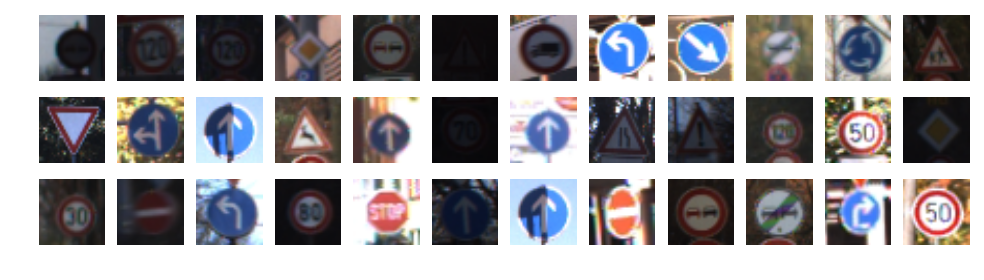

In [5]:
# Plot a randomly chosen sample of images from the training data set
image_rows, image_cols = (3, 12)
images_to_plot = np.random.randint(0, n_train, size=(image_rows, image_cols))
plt.figure(figsize=(image_cols, image_rows))
for i, v in enumerate(images_to_plot.flatten()):
    plt.subplot(images_to_plot.shape[0], images_to_plot.shape[1], i+1)
    plt.imshow(X_train[v])
    plt.axis('off')

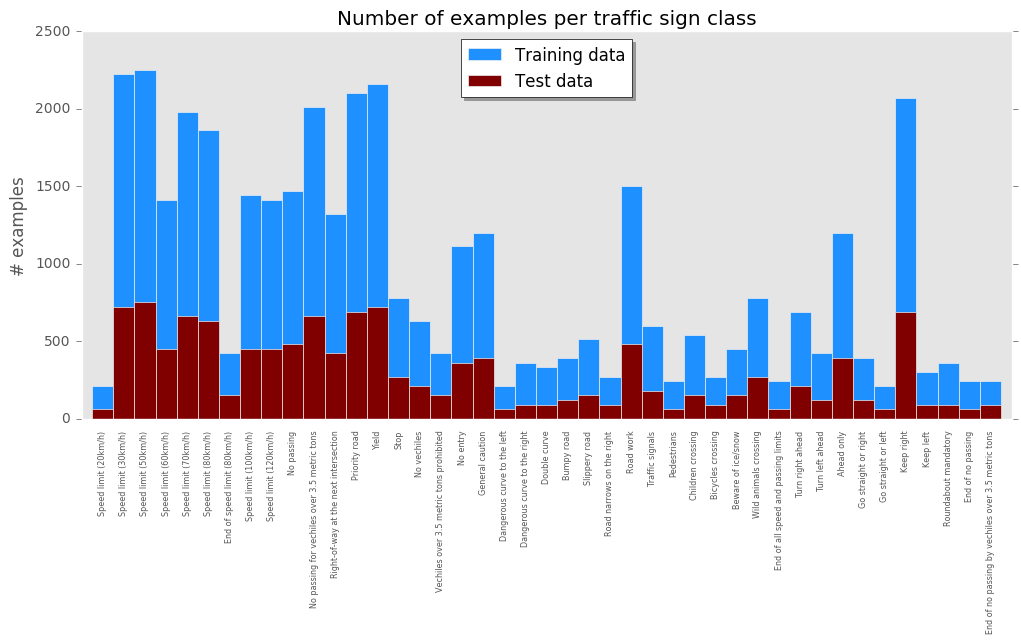

In [6]:
# Read mapping of class number to class description
df = pd.read_csv("signnames.csv")
class_table = df['SignName'].values

def plot_histogram(ys, labels, colors, title):
    """
    Plot a histogram of the frequency of each class in the supplied ys.
    
    All ys must have the same classes.
    """
    n_classes = np.unique(ys[0]).shape[0]
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    for i, y in enumerate(ys):
        ax.bar(range(n_classes), np.bincount(y), width=1., align='center', color=colors[i], label=labels[i])
    
    plt.xlim([-1, n_classes])
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.grid(False)
    ax.set_xticks(range(n_classes))
    ax.set_xticklabels(class_table, rotation=90, size='xx-small')
    legend = ax.legend(loc='upper center', shadow=True)
    legend_frame = legend.get_frame()
    legend_frame.set_facecolor('white')
    legend_frame.set_edgecolor('black')
    plt.ylabel('# examples')
    plt.title(title)
    
    
plot_histogram([y_train, y_test], ['Training data', 'Test data'], ['dodgerblue', 'maroon'],
              "Number of examples per traffic sign class")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
# Utility functions for data augmentation

def rotate_image(img, angle=None):
    """Rotate an image
    
    If angle is not provided rotates the image by a randomly
    sampled number of degrees in the range [-15, 15].
    """
    if angle is None:
        angle = np.random.uniform(-15, 15)
    rows, cols, ch = img.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, rotation_matrix, (cols, rows))

def shear_image(img, factor=3):
    """Apply shear transform to image.
    
    Control points in the image (coordinates (5,5), (20, 5), (5, 20)) are shifted 
    by a randomly sampled amount in the range [-factor, factor]. Note that this is an
    affine transformation, i.e., parallel lines in the original remain parallel 
    in the transformed image.
    """
    rows, cols, ch = img.shape
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+np.random.uniform(-factor, factor)
    pt2 = 20+np.random.uniform(-factor, factor)
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    
    shear_matrix = cv2.getAffineTransform(pts1,pts2)
    
    return cv2.warpAffine(img, shear_matrix, (cols, rows))
    
def jitter_image(img, factor=10):
    """Add noise to or jitter the luminance of the image.
    
    Noise is uniformly sampled from the range [-factor, factor].
    The image is converted to YUV colorspace and the sampled noise is 
    added to each pixel of the Y component. The result is clipped to 
    ensure it remains between 0 and 255.
    """
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = np.minimum(255, np.maximum(0, 
        img_yuv[:, :, 0] + np.random.randint(-factor, factor, img.shape[:2]))).astype('uint8')
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def crop_resize_image(img, factor=4):
    """Crop image and resize back to original size.
    
    Image is cropped by a uniformly sampled amount in the range [0, factor]."""
    margins = np.random.randint(0, factor, 4)
    img_cropped = img[margins[0]:, margins[2]:]
    if margins[1] > 0:
        img_cropped = img_cropped[:-margins[1], :]
    if margins[3] > 0:
        img_cropped = img_cropped[:, :-margins[3]]
    return cv2.resize(img_cropped, img.shape[:2])

def augmentation_pipeline(img):
    """Data augmentation pipeline.
    
    Combines jittering, rotation, shearing and crop/resize operations."""
    img_out = jitter_image(img)
    img_out = rotate_image(img_out)
    img_out = shear_image(img_out)
    return crop_resize_image(img_out)

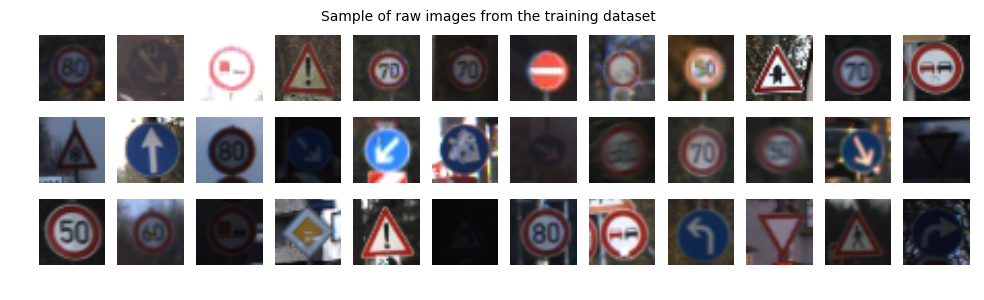

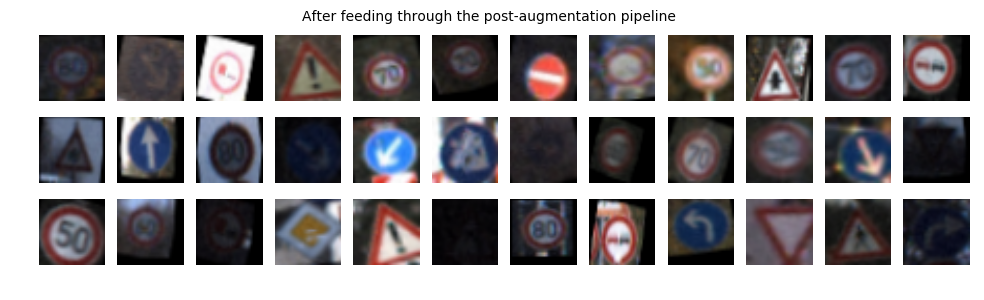

In [8]:
# Some examples of the image pipeline for data augmentation.
# Compare original images from dataset with output images from pipeline
images_to_plot = np.random.randint(0, n_train, size=(image_rows, image_cols))
plt.figure(figsize=(image_cols, image_rows))
plt.suptitle("Sample of raw images from the training dataset")
for i, v in enumerate(images_to_plot.flatten()):
    plt.subplot(images_to_plot.shape[0], images_to_plot.shape[1], i+1)
    plt.imshow(X_train[v])
    plt.axis('off')

plt.figure(figsize=(image_cols, image_rows))
plt.suptitle("After feeding through the post-augmentation pipeline")
for i, v in enumerate(images_to_plot.flatten()):
    plt.subplot(images_to_plot.shape[0], images_to_plot.shape[1], i+1)
    plt.imshow(augmentation_pipeline(X_train[v]))
    plt.axis('off')

### Dataset Augmentation

The code cell below ensures there are equal number of samples for each sign class in the training data to avoid biasing the model.
If a traffic sign class has less than the target number, augments the data with `target - actual` number of new samples. Each new sample is generated from a randomly chosen image in the training set of the given category.

In [9]:
max_per_class = 5000
samples_per_class = np.bincount(y_train)
target_samples_per_class = np.maximum(max_per_class, np.max(samples_per_class))

total_new_samples = sum(target_samples_per_class - x for x in samples_per_class)
new_Xs = np.zeros((total_new_samples,) + image_shape, dtype=X_train.dtype)
new_ys = np.zeros((total_new_samples,), dtype=y_train.dtype)

idx = 0
for c, data_samples in enumerate(samples_per_class):
    sample_ids = np.where(y_train == c)[0]
    new_samples = target_samples_per_class - data_samples
    samples = X_train[np.random.choice(sample_ids, target_samples_per_class - data_samples)]
    new_ys[idx:idx+new_samples] = c*np.ones(new_samples)
    for s in samples:
        new_Xs[idx] = augmentation_pipeline(s)
        idx += 1
        
X_train = np.vstack((X_train, new_Xs))
y_train = np.concatenate((y_train, new_ys))
print("Augmented dataset with {} new images".format(total_new_samples))

# We now have evenly distributed samples over the different classes
#plot_histogram(y_train, 'Traffic sign classes in augmented data')

Augmented dataset with 175791 new images


In [10]:
# Reserve 20% of the dataset for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### Dataset Pre-processing

In [11]:
def preprocess(X):
    """Convert to grayscale and apply CLAHE to an image dataset.
    
    Performs contrast limited adapted histogram equalization (CLAHE) 
    to improve the contrast of the images in the dataset.
    """
    if not hasattr(preprocess, 'clahe'):
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4,4))
    X_new = np.zeros(X.shape[:-1]+(1,), dtype='uint8')
    for i in range(len(X)):
        X_new[i] = clahe.apply(cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)).reshape(32, 32, 1)
    return X_new, X

In [12]:
X_train, _ = preprocess(X_train)
X_val, _ = preprocess(X_val)
X_test, _ = preprocess(X_test)

### Dataset Normalization

Normalize all datasets to zero mean and unit standard deviation.
The sample statistics are calculated on the training dataset.

In [13]:
train_mean = np.mean(X_train, axis=0)
train_stdev = np.std(X_train, axis=0)
X_train = (X_train-train_mean)/train_stdev
X_val = (X_val-train_mean)/train_stdev
X_test = (X_test-train_mean)/train_stdev

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

---
First, I converted the images to grayscale as I found that training the model using grayscale images markedly improved model accuracy for my chosen model architecture. This is also in agreement with the findings of Sermanet and LeCun.

Many images in the dataset suffer from poor contrast. To improve the contrast I applied an image processing technique called contrast limited adaptive histogram equalization (CLAHE). This method spreads out the pixel intensities across the full range of values using the cumulative density function of intensities in each part of the image.

I have also normalized the data by subtracting the sample mean and dividing by the sample standard deviation. The sample statistics are calculated across all training images. This is often referred to as data normalization and is a common preprocessing step for many machine learning algorithms. After normalization the input data exhibits zero mean and unit standard deviation across all features (pixels). Normalization can help improve robustness and convergence of the learning process as it ensures that the feature dimensions, in this case pixel intensities, are on the same scale.

---

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

---
The dataset contains 39209 training images, which may not be sufficiently large and is likely to lead to overfitting when using models with high entropic capacity, such as most deep learning models. Ideally, one would gather more data, but this may well be an expensive or even unfeasible process in practice. 

The traffic sign images dataset is also unbalanced - it is not evenly distributed across all possible classes and instead it exhibits skewed class distribution. For example, as shown in histograms above, there are many examples of keep right signs compared to keep left, many more examples of 30 km/h speed limit signs compared to 20 km/h, etc. This is not unusual - datasets in practice are often non-uniformly distributed. For example, for traffic signs one would expect yield signs, speed limit signs and keep right signs (this being a German signs dataset) to be much more common.

The skewed distribution of the different classes in the dataset can affect the model being trained, biasing it towards classes that appear more often. This means that, all else being equal, the model is likely to assign a higher probability to these classess.

To reduce the risk of overfitting and to mitigate the skewed distribution of the data I augmented the dataset with new generated images by choosing an image at random and applying the following transformations:
 * image rotation by a randomly sampled number of degrees;
 * shearing the image;
 * adding random noise to the brightness of each pixel;
 * cropping/removing a small amount of pixels from each side of the image and resizing back to its original size.
 
I repeated this process until each traffic sign class had an equal number of samples.

I then shuffled and split the augmented training data, reserving 20% for the validation set. 

---

In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

stddev = 0.1

# variable_summaries function copied from TensorBoard tutorial 
# https://www.tensorflow.org/how_tos/summaries_and_tensorboard/
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

def relu(x):
    """Create a ReLU activation layer on top of x."""
    layer = tf.nn.relu(x, name='activation')
    tf.summary.histogram('activations', layer)
    return layer

def conv_relu(layer_id, x, num_filters, filter_size=3):
    """Create a convolutional layer, followed by a ReLU layer."""
    shape = x.get_shape()
    with tf.name_scope('weights'):
        W = tf.Variable(tf.truncated_normal((filter_size, filter_size, 
                                             shape[-1].value, num_filters), stddev=stddev),
                        name = 'ConvW' + str(layer_id))
        variable_summaries(W)
    with tf.name_scope('biases'):
        b = tf.Variable(tf.zeros(num_filters), name = 'Convb' + str(layer_id))
        variable_summaries(b)
    with tf.name_scope('convolutions'):
        conv = tf.nn.conv2d(x, W, [1,1,1,1], padding='SAME') + b
        tf.summary.histogram('pre_activations_conv', conv)

    return relu(conv), W, b

def max_pool(x):
    """Create a max pool layer."""
    with tf.name_scope('MaxPool'):
        res = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], 
                             padding='VALID', name="max_pool")
        tf.summary.histogram('pooling', res)
    return res

def fc(layer_id, x, output_size):
    """Create a fully connected layer."""
    shape = x.get_shape()
    with tf.name_scope('weights'):
        W = tf.Variable(tf.truncated_normal((shape[-1].value, output_size), stddev=stddev),
                        name = 'FCW' + str(layer_id))
        variable_summaries(W)
    with tf.name_scope('biases'):
        b = tf.Variable(tf.zeros(output_size), name = 'FCW' + str(layer_id))
        variable_summaries(b)
    with tf.name_scope('Wx_plus_b'):
        res = tf.matmul(x, W) + b, W, b
        #tf.summary.histogram('pre_activations_fc', res)
    return res

def dropout(x, keep_prob):
    """Create a dropout layer with keep probability of keep_prob."""
    with tf.name_scope('dropout'):
        layer = tf.nn.dropout(x, keep_prob)
    return x

In [15]:
def thenet(x, keep_prob_cn=None, keep_prob_fc=None):
    """Create the target deep neural network architecture given input placeholder x.
    
    keep_prob_cn holds the dropout keep probability used after (some) convolutional layers.
    keep_prob_fc holds the dropout keep probability used after fully-connected layers.
    """
    # Two conv+relu layers with 32 filters in each filter bank, 
    # followed by a max pool and an optional dropout layer
    layer_id = 1
    Ws = []
    layer, W, _ = conv_relu(layer_id, x, num_filters=32)
    layer_id += 1
    Ws.append(W)
    layer, W, _ = conv_relu(layer_id, layer, num_filters=32)
    layer_id += 1
    Ws.append(W)
    layer_p1 = max_pool(layer)
    if keep_prob_cn is not None:
        layer_p1 = dropout(layer_p1, keep_prob_cn)
    
    # Two conv+relu layers with double the filter bank capacity of the previous layer, 
    # followed by a max pool and an optional dropout layer
    layer = layer_p1
    layer, W, _ = conv_relu(layer_id, layer, 64)
    layer_id += 1
    Ws.append(W)
    layer, W, _ = conv_relu(layer_id, layer, 64)
    layer_id += 1
    Ws.append(W)
    layer_p2 = max_pool(layer)
    if keep_prob_cn is not None:
        layer_p2 = dropout(layer_p2, keep_prob_cn)

    # Two conv+relu layers with double the filter bank capacity of the previous layer, 
    # followed by a max pool and an optional dropout layer
    layer = layer_p2
    layer, W, _ = conv_relu(layer_id, layer, 128)
    layer_id += 1
    Ws.append(W)
    layer, W, _ = conv_relu(layer_id, layer, 128)
    layer_id += 1
    Ws.append(W)
    layer_p3 = max_pool(layer)
    if keep_prob_cn is not None:
        layer_p3 = dropout(layer_p3, keep_prob_cn)

    # Fully-connected layer, with (skip) connections from each 2xconv-relu-pool unit,
    # followed by a dropout layer. 
    # 14336 -> 256, where 14336 = 4*4*128 + 8*8*64 + 16*16*32
    layer = tf.concat(1, [flatten(l) for l in [layer_p1, layer_p2, layer_p3]])
    layer, W, _ = fc(layer_id, layer, 256)
    layer_id += 1
    Ws.append(W)
    layer = relu(layer)
    if keep_prob_fc is not None:
        layer = dropout(layer, keep_prob_fc)
    
    # 256 -> 84 fully-connected layer, followed by a dropout layer
    layer, W, _ = fc(layer_id, layer, 84)
    layer_id += 1
    Ws.append(W)
    layer = relu(layer)
    if keep_prob_fc is not None:
        layer = dropout(layer, keep_prob_fc)

    # Last fully-connected layer, outputting the correct number of dimensions to
    # equal number of traffic sign classes, ready for one-hot encoding.
    layer, W, _ = fc(layer_id, layer, n_classes)
    Ws.append(W)
    
    # counting only layers that have trainable weights
    print("Created {}-layer TheNet.".format(layer_id))
    # return last layer and all weights
    return layer, Ws
    
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')
y = tf.placeholder(tf.int32, (None,), name='y')
one_hot_y = tf.one_hot(y, n_classes)
keep_prob_fc = tf.placeholder(tf.float32, name='keep_prob_fc') # dropout keep probability fully connected layers
keep_prob_cn = tf.placeholder(tf.float32, name='keep_prob_cn') # dropout keep probability convolutional layers
tf.summary.scalar('fc_dropout_keep_probability', keep_prob_fc)
tf.summary.scalar('cn_dropout_keep_probability', keep_prob_cn)

<tf.Tensor 'cn_dropout_keep_probability:0' shape=() dtype=string>

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

---
![TheNet Architecture](images/thenet.png "TheNet Architecture")

The final architecture consists of three 3x3 filter convolutional units with dimensions 32, 64 and 128 respectively. The convolutional units are followed by three fully-connected units. A softmax classifier is used to turn the 43-dimensional scores from the last layer into a probability score.

Each convolutional unit consists of the following layers:
* convolutional layer
* ReLU activation layer
* convolutional layer
* ReLU activation layer
* max-pooling layer
* dropout layer

Convolutional layers all use 3x3 filters with a stride of 1 and padding to preserve the input size. Max-pooling layers have a size of 2 and stride of 2 (i.e., the height and width of the input is halved after each max-pooling layer). Dropout layers drop 50% of the filter output at random during training.

The fully-connected unit is a fully-connected layer followed by a dropout layer, except for the last unit, which does not have a dropout layer and directly outputs the final 43-dimensional output vectors.

There is a (skip) connection to the first fully-connected layer from all convolutional units. That is, the first fully connected layer takes the concatenated raw output of the 1st, 2nd and 3rd convolutional units.

The architecture is vaguely inspired from the success of networks such as ResNet, which use repeated fixed size small filters (e.g., 3x3) with a growing size of filter banks (32, 64 and 128 in this case) and shortcut connections. Of course, this network can be much shallower than top performing networks trained on ImageNet.

---

In [16]:
epochs = 5
batch_size = 256

learning_rate = 1e-5 # starting value for training from random weights was 1e-3
regularization = 5e-4 # starting value 1e-5

cn_dropout_keep_probability = 0.5
fc_dropout_keep_probability = 0.5

In [17]:
logits, Ws = thenet(x, keep_prob_cn, keep_prob_fc)
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    with tf.name_scope('total'):
        loss = tf.reduce_mean(cross_entropy)
        for w in Ws:
            loss += regularization*tf.nn.l2_loss(w)

tf.summary.scalar('loss', loss)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

Created 9-layer TheNet.


In [18]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    with tf.name_scope('accuracy'):
        accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
tf.summary.scalar('accuracy', accuracy_op)
merged_summaries = tf.summary.merge_all()
summary_dir = 'logs/'

In [19]:
def evaluate(Xs, ys):
    num_examples = len(Xs)
    total_accuracy = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = Xs[offset:offset+batch_size], ys[offset:offset+batch_size]
        summary, accuracy = sess.run([merged_summaries, accuracy_op], 
                                     feed_dict={x: batch_x, 
                                                y: batch_y, 
                                                keep_prob_cn: 1.,
                                                keep_prob_fc: 1.})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy/num_examples, summary

In [20]:
# id manually set to separate different training sessions for visualization and weights backup purposes
train_idx = '14'
# set to False when first training a model (random weights), 
# set to True when loading weights from file
load_previous_model = True
save_session = False

In [21]:
saver = tf.train.Saver()
train_writer = tf.summary.FileWriter(summary_dir + 'train' + train_idx)
val_writer = tf.summary.FileWriter(summary_dir + 'val' + train_idx)

In [25]:
with tf.Session() as sess:
    if load_previous_model:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
    else:
        tf.global_variables_initializer().run()
        
    num_examples = len(X_train)
    
    print("Starting training...")
    
    step = 0
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            step += 1
            batch_x, batch_y = X_train[offset:offset+batch_size], y_train[offset:offset+batch_size]
            summary, _ = sess.run([merged_summaries, training_op], 
                                  feed_dict = {x: batch_x, 
                                               y: batch_y,
                                               keep_prob_cn: cn_dropout_keep_probability,
                                               keep_prob_fc: fc_dropout_keep_probability})
            train_writer.add_summary(summary, step)
            
        step += 1
        training_accuracy, summary = evaluate(X_train, y_train)
        train_writer.add_summary(summary, step)
        step += 1
        validation_accuracy, summary = evaluate(X_val, y_val)
        val_writer.add_summary(summary, step)
        print("Epoch {}, training accuracy {:.3f}, validation accuracy {:.3f}".format(
                i, training_accuracy, validation_accuracy))
    
    if save_session:
        saver.save(sess, 'thenet' + train_idx)
    print("Training complete.")

Starting training...
Training complete.


### Test set accuracy - 98.1%

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('sessions/'))
    
    test_accuracy, _ = evaluate(X_test, y_test)
    print("Test accuracy {:.3f}".format(test_accuracy))

Test accuracy 0.981


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

---
The network was trained using the Adam update rule for parameter optimization. Adam is an adaptive learning rate method with momentum and is often recommended as the default optimizer to use (e.g., http://cs231n.github.io/neural-networks-3/#update for a good discussion on parameter optimization).

I used the cross-entropy loss function with added L2 regularization for all weights. Batch size was fixed at 256.

The starting values for the hyperparameters were chosen with a combination of random and grid search. I used 5-fold cross-validation on the training set and trained the model from scratch for 10 epochs for each choice of hyperparameters.

I then trained the network in stages as follows:
1. I started with a learning rate of `1e-3` and regularization rate of `1e-5` using a random initialization of the weights. I trained the network for 10 epochs, after which the accuracy/loss started to plateau close to 95%.
2. I then reduced the learning rate to `5e-4` and increased the regularization rate to `5e-4`. I trained for 7 epochs, by which time the accuracy again plateaued, this time at around 98%.
3. I reduced the learning rate further to `1e-4`, keeping the regularization rate the same. I trained for 5 more epochs.
4. I reduced the learning rate further to `1e-5`. I trained for another 5 epochs, by which time training accuracy was at 99.9%.

---

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---
I started with LeNet architecture that we developed in the LeNet lab. LeNet was an excellent starting point as it is very quick to train, yet quite powerful. I kept the net architecture the same and focused exclusively on exploring the data and working on pre-processing and data augmentation techniques to get the best possible performance with LeNet. 

One of the first things I tried was data normalization, de-meaning and standardizing each pixel to unit variance. This showed a marked improvement in accuracy. However, the biggest gain from pre-processing came from converting all images to grayscale. This was quite surprising to me as intuitively I expected the color information to be implicitly useful to the network. 

In terms of my own human vision performance on the dataset I noticed that contrast played a huge part, with some signs barely identifiable by me. Once I converted to grayscale I tried techniques such as adaptive histogram equalization and variations of this technique such as CLAHE to improve contrast. Perhaps surprisingly, these techniques did not help the network as much as they did for my human vision recognition, but there seemed to be a potential small improvement in network performance as well, so I decided to use CLAHE.

By this time the network was already easily overfitting even with just 10-15 epochs of training on the original dataset, so I started experimenting with deep learning techniques that have proven useful in combating overfitting, such as regularization and dropout. This brought down the amount of overfitting and therefore the training accuracy, essentially giving me more room to train and optimize the model.

Then I started looking at data augmentation techniques to grow my training data. Some approaches, such as image translation/shifting, seemed to confuse the network, probably due to the added columns and rows of black pixels. Other approaches such as rotation, cropping, shearing and jittering made a significant positive difference.

I went back and forth between more or less aggressive augmentation, learning & regularization rates, etc., to get a feel for the network training. I compared results for a choice of techniques and hyperparameters by training LeNet from scratch for 15 epochs and threw away the weights. I picked the best model and measured the test accuracy once - I achieved 96.8% on the test set with LeNet.

I fixed the pre-processing and data augmentation process based on the best LeNet model above and started desigining a CNN arhitecture from scratch based on the example networks I've seen in papers that have made recent advances on ImageNet. I experimented mostly with small filter sizes (3x3s and 5x5s), larger filter bank sizes, the placement of max-pooling and dropout layers, the size of fully-conected layers, as well as the choice of hyperparameters. 

I found out that some of my chosen networks had a lot of capacity and given sufficient compute resources, most networks can easily overfit the training set with up to 99.8% validation accuracy after 15-20 epochs. One of the few still working levers at that stage seemed to be repeatedly increasing the size of the augmented data set, as well as simply regenerating it afresh after every 5 epochs. I focused my efforts on finetuning the learning process after reaching a high enough accuracy as after a certain level it seemed to oscillate, unable to improve further. I was manually reducing the learning rate, increasing regularization and dropout. After each change I trained from a previously saved set of weights for another 5 epochs on a freshly augmented dataset to understand what works. I used TensorBoard to monitor how the weights, the loss and accuracy varied over time.

---

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

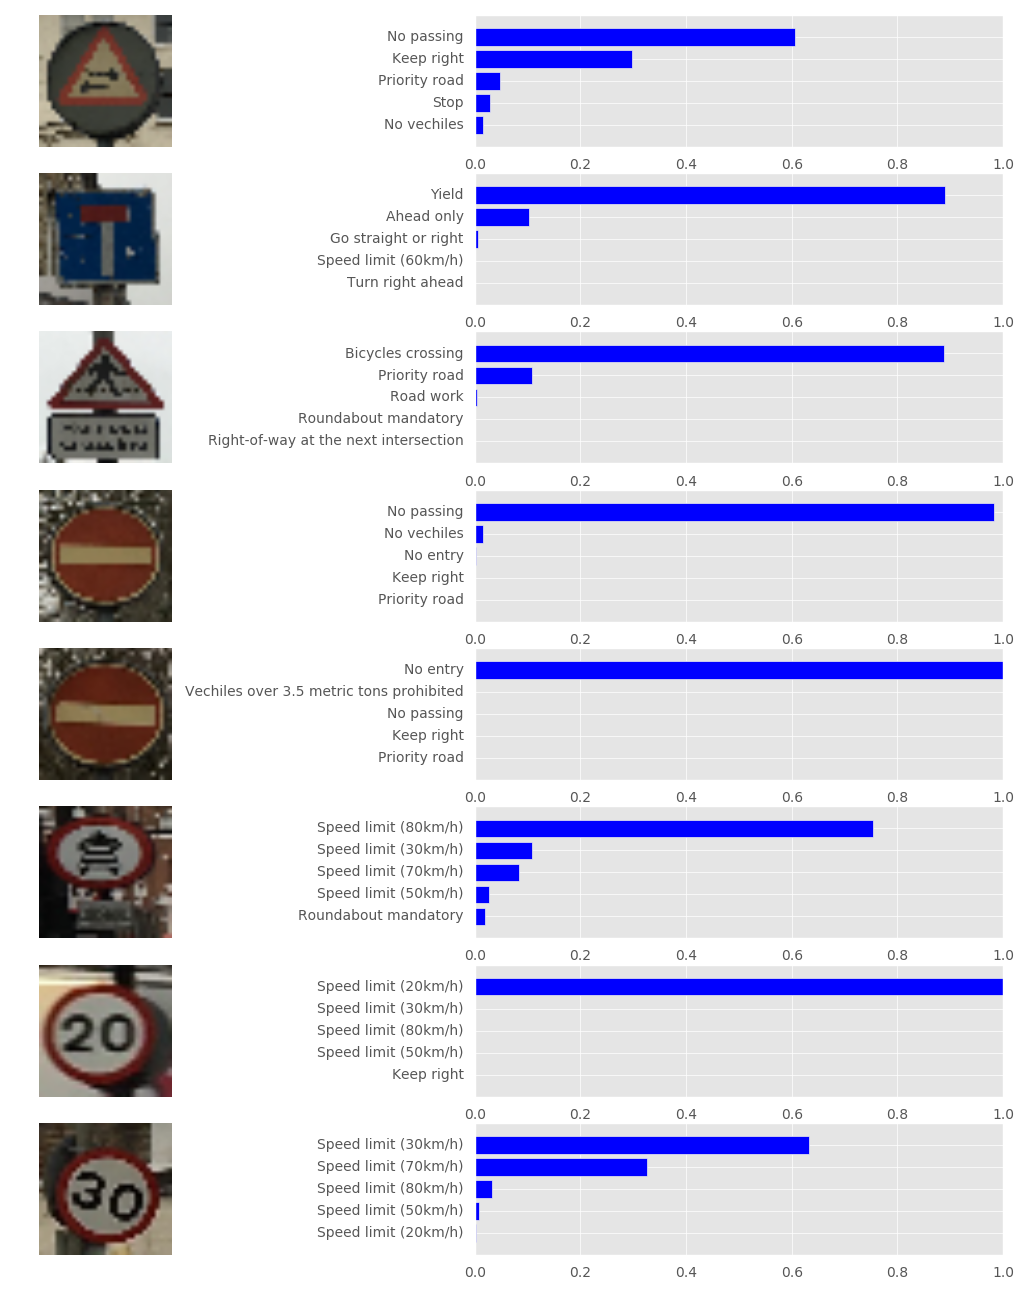

In [23]:
img_idxs = range(1,9)
imgs = np.zeros((len(img_idxs), ) + image_shape, dtype='uint8')

for i in img_idxs:
    img = cv2.cvtColor(cv2.imread('images/img' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
    # resize down to 32x32
    imgs[i-1] = cv2.resize(img, image_shape[:2])
    
def predict(imgs):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('sessions/.'))
        predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), 
                               feed_dict = {x: (imgs-train_mean)/train_stdev,
                                            keep_prob_cn: 1.,
                                            keep_prob_fc: 1.})
    return predictions

imgs, imgs_orig = preprocess(imgs)
predictions = predict(imgs)

plt.figure(figsize=(15, len(img_idxs)*2))
for i in img_idxs:
    plt.subplot(len(img_idxs), 2, 2*i-1)
    plt.imshow(imgs_orig[i-1])
    plt.axis('off')
    plt.subplot(len(img_idxs), 2, 2*i)
    plt.barh(np.arange(5), predictions.values[i-1], align='center', color='blue')
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    ax = plt.gca()
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(class_table[predictions.indices[i-1]])
    ax.set_xlim([0,1])
    ax.invert_yaxis()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

**Answer:**

---
I have provided 8 images above, which were cut out from photos taken by me close to my house in London, United Kingdom. 3 of these images have no correspondence in the German traffic signs dataset used to train the model. It is not possible for the model to classify these correctly as it has not been trained on such classes of signs. The remaining signs I expected to be relatively easy to classify as they appear to have sufficient brightness and contrast, and are not occluded in any way. However, results show that small local variations can easily confuse the model and lead to misclassification.

1. UK sign which signals that a one-way street is crossing a two-way street. Not in training dataset. The two opposite arrows are difficult to distinguish because of the low resolution.
2. UK sign signaling a dead end street. Not in training dataset. Interestingly, the top prediction is for a yield sign, which has a triangular shape.
3. UK sign signaling a pedestrian crossing. While the sign is very similar to the German version, the shape of the man painted on the sign is actually quite a bit different with curvy lines. There is also a dotted line in the UK version. This seems to be enough to completely confuse the model as none of the top 5 predictions are correct.
4. No entry sign. This and the next one are the same type of signs, but are two different physical signs with very similar background. Very interesting results - model failed to recognize the first sign (very small probability score for the correct result in third position), while it classified the second sign correctly with a 100% score.
5. No entry sign, classified correctly.
6. Sign restricting access for cars and motorcycles (public buses only street). Not in the training dataset. The model classifies this as a speed limit sign, which can be explained by it's shape and color similarity to a speed sign.
7. Speed limit 20, classified correctly.
8. Speed limit 30, classified correctly. The model has the right answer as it's first choice, however the certainty is only about 60%. This is most likely because the sign is rotated to the right (this is it's actual physical position). 
---

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

No, as shown above the model is easily tripped by new images. For classes which were seen in the training data the accuracy is 60% (3/5) if just the top 1 result is taken. While this is a very small sample size of 5, the results do not come close to the reported test set accuracy of 98.1%. This suggests that the model has overfit to the training set and does not generalize very well to new images, especially when the images exhibit small design variations (e.g., UK vs German traffic signs).

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

---
The results for the no entry signs were quite notable. One of the signs was classified correctly, with almost all probability mass assigned to the correct answer. The other sign was classified incorrectly even though it is very similar to a human eye. The right answer was in the 3rd position, but the probability score was very low. This corroborates findings in the deep learning field that show how easy it can be to trip or fool a trained neural net.

The model was very certain when tested against speed signs, correctly guessing and with other speed signs in the next 3 positions. The 30 speed limit sign was classified correctly, with 70 speed limit as the second choice of the model, which appears sensible given the sign rotation with the tilted 3 roughly resembling a 7.

The pedestrian crossing sign was not classified correctly at all in the top 5. While the sign is quite similar at first sight, there are noteable differences which can explain this result, as mentioned previously.

---

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.